# Simulate from FEM

## Imports


:::{.callout-warning}
You need to modify  `ZOOMY_AMREX_HOME` below to point to your local AMReX installation
:::

In [1]:
import os
from pathlib import Path
import sys
import rasterio
os.environ['PYTHONPATH'] = os.path.join(os.getcwd(), '../../..')
os.environ['ZOOMY_DIR'] = os.path.join(os.getcwd(), '../../..')
os.environ['ZoomyLog'] = 'Default'
os.environ['ZoomyLogLevel'] = 'INFO'
os.environ['JAX_ENABLE_X64'] = 'True'
os.environ['ZOOMY_AMREX_HOME'] = '/home/is086873/MBD/Git/amrex'


project_root = Path.cwd().parents[2]  # 0=current, 1=.., 2=../..
sys.path.append(str(project_root))

In [ ]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
from sympy import Matrix

from zoomy_core.fvm.solver_jax import Settings
from zoomy_core.model.models.shallow_water import ShallowWaterEquations
from zoomy_core.model.models.shallow_moments_topo import ShallowMomentsTopo, ShallowMomentsTopoNumerical


import zoomy_core.model.initial_conditions as IC
import zoomy_core.model.boundary_conditions as BC
from zoomy_core.misc.misc import Zstruct
import zoomy_core.transformation.to_amrex as trafo
from tutorials.amrex.helper import create_artificial_raster, show_raster, transform_tiff

## Read raster data

2119.715620611168 -0.22698929399103876 -0.00021292724603619957
Inclination angle: alpha: -12.79 degrees ; theta: -0.01 degrees
0.029961072081822165 -5.212249583064369e-06 -1.1138400164830554e-07
Inclination angle: alpha: -0.00 degrees ; theta: -0.00 degrees
Tilt angle (degrees): -12.79


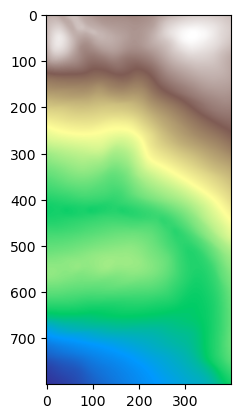

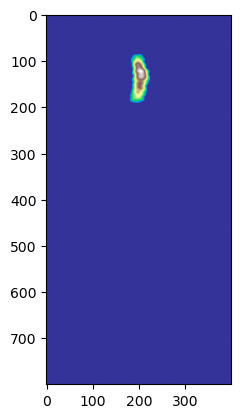

In [ ]:
main_dir = os.getenv("ZOOMY_DIR")
dem_path = os.path.join(main_dir, 'data/ca_elev.tif')
ic_water_path = os.path.join(main_dir, 'data/ca_debrisflow.tif')
angle = 0.0

# dem_path = os.path.join(main_dir, 'data/evel_artificial.tif')
# ic_water_path = os.path.join(main_dir, 'data/release_artificial.tif')
# N = 100
# dx = 5.
# M = N * dx
# create_artificial_raster(lambda x, y: 1*np.exp((-(x+0.5*M)**2-y**2)/M/10), (-M, M, -M, M), dx, ic_water_path)
# create_artificial_raster(lambda x, y: 100 * np.exp(-(x+M)**2/M**2), (-M, M, -M, M), dx, dem_path)

# create_artificial_raster(lambda x, y: 1.*np.exp((-(x-1000)**2-(y-3000)**2)/10000.), (0, 2000, 0, 4000), 5, ic_water_path)
# ic_water_path, _ = transform_tiff(ic_water_path, tilt=False)


zoom = [[0, 800], [700,1100]]  # [ymin,ymax], [xmin,xmax]
dem_path, angle = transform_tiff(dem_path, tilt=True, scale=1, zoom=zoom)
ic_water_path, _ = transform_tiff(ic_water_path, tilt=False, scale=1, zoom=zoom)
print(f'Tilt angle (degrees): {angle:.2f}')

show_raster(dem_path)
show_raster(ic_water_path)


## Model definition

In [ ]:
# Currently, BCs are not implemented in AMReX and periodic BCs are applied
bcs = BC.BoundaryConditions(
    [
        BC.Extrapolation(tag="N"),
        BC.Extrapolation(tag="S"),
        BC.Extrapolation(tag="E"),
        BC.Extrapolation(tag="W"),
    ]
)


class MyModel(ShallowMomentsTopoNumerical):
    def source(self):
        out = Matrix([0 for i in range(self.n_variables)])
        # out += self.inclination()
        out += self.newtonian()
        out += self.slip_mod()
        # out += self.chezy()
        return self.substitute_precomputed_denominator(out, self.variables[1], self.aux_variables.hinv)
         

level = 0
model = MyModel(
    level=level,
    boundary_conditions=bcs,
    parameters=Zstruct(ey=np.sin(np.radians(-angle)), ez=np.cos(np.radians(-angle)), nu=0.000001, lamda=1/1000., rho=1000, c_slipmod=1/30, C=300),
    # aux_variables = ['hinv'] + [f'dalpha_{i}_dx' for i in range(level+1)] + [f'dbeta_{i}_dy' for i in range(level+1)],
    aux_variables = ['hinv'],
    
)



In [ ]:
print(model.parameters.keys())
print(model.parameter_values)

['g', 'ex', 'ey', 'ez', 'eps_low_water', 'rho', 'nu', 'lamda', 'c_slipmod', 'C']
[9.81000000e+00 0.00000000e+00 2.21358269e-01 9.75192554e-01
 1.00000000e-06 1.00000000e+03 1.00000000e-06 1.00000000e-03
 3.33333333e-02 3.00000000e+02]


In [ ]:
# model.source()

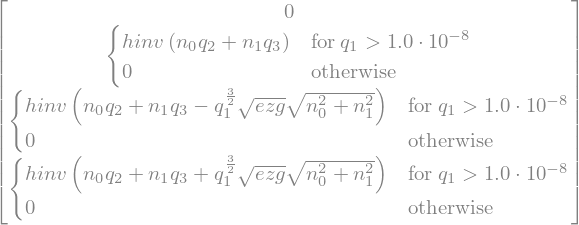

In [ ]:
model.eigenvalues()

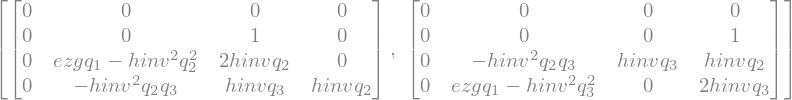

In [ ]:
model.quasilinear_matrix()

## Code transformation and AMReX compilation

currently, we always "clean" and compile from scratch. Comment out "make clean" to disable.

In [ ]:

import shutil
from pathlib import Path
settings = Settings(name="ShallowMoments", output=Zstruct(directory=f"outputs/amrex_{level}"))
source_dir = Path(os.path.join(main_dir, 'library/amrex/Exec'))
output_dir = Path(os.path.join(main_dir, settings.output.directory))

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

trafo.write_code(model, settings)
main_dir = os.getenv("ZOOMY_DIR")
os.environ['ZOOMY_AMREX_MODEL'] = os.path.join(main_dir, os.path.join(settings.output.directory, '.c_interface'))

2025-09-24 16:05:57.966 | WARNING  | library.core.misc.misc:__init__:143 - No 'filename' attribute found in output Zstruct. Default: 'simulation'
2025-09-24 16:05:57.969 | WARNING  | library.core.misc.misc:__init__:146 - No 'clean_directory' attribute found in output Zstruct. Default: False


In [ ]:
import subprocess

base = os.path.join(os.environ['ZOOMY_DIR'], 'library/amrex/')
cmds = [
    f"cp ../../{settings.output.directory}/.c_interface/model.h ./Source/model.h",
    "source ~/.zshrc",
    "source setup.sh",
    "cd Exec",
    # "make clean",
    "make"
]

subprocess.run(" && ".join(cmds), shell=True, executable="/bin/zsh", cwd=base)



setup.sh:4: command not found: module
setup.sh:5: command not found: module
setup.sh:6: command not found: micromamba


CompletedProcess(args='cp ../../outputs/amrex_0/.c_interface/model.h ./Source/model.h && source ~/.zshrc && source setup.sh && cd Exec && make', returncode=127)

## Prepare raster data for AMReX

... and copy stuff to the output directory ...

In [ ]:


output_dir.mkdir(parents=True, exist_ok=True)  # make sure output folder exists

for item in source_dir.iterdir():
    dest = output_dir / item.name
    if item.is_dir():
        shutil.copytree(item, dest, dirs_exist_ok=True)
    else:
        shutil.copy2(item, dest)
        
shutil.copy(dem_path, output_dir)
shutil.copy(ic_water_path, output_dir)

print("The simulation output will be written to: ", output_dir)

from amrex.preprocess_rasterdata import preprocess
preprocess(os.path.join(output_dir, 'inputs'), dem_path, ic_water_path)


The simulation output will be written to:  /home/ingo/Git/Zoomy/web/tutorials/amrex/../../../outputs/amrex_0
✓ raw files: adjusted_ca_elev.raw adjusted_ca_debrisflow.raw
✓ inputs updated → /home/ingo/Git/Zoomy/outputs/amrex_0/inputs


## Do the Simulation

run in the notebook or as a batch job

In [ ]:
run_in_notebook = False

In [ ]:
if (run_in_notebook):
    base = os.path.join(os.environ['ZOOMY_DIR'], 'library/amrex/')
    cmds = [
        "source ~/.zshrc",
        "source setup.sh",
        f"cd ../../{settings.output.directory}",
        "./clean.sh",
        "mpiexec -np 4 ./main3d.gnu.MPI.ex inputs",
    ]

    subprocess.run("\n".join(cmds), shell=True, executable="/bin/zsh", cwd=base)
else:
    
    base = os.path.join(os.environ['ZOOMY_DIR'], 'library/amrex/')
    cmds = [
        "source ~/.zshrc",
        "source setup.sh",
        f"cd ../../{settings.output.directory}",
        "./clean.sh",
        "sbatch batch.sh < inputs",
    ]

    subprocess.run("\n".join(cmds), shell=True, executable="/bin/zsh", cwd=base)

        

setup.sh:4: command not found: module
setup.sh:5: command not found: module
setup.sh:6: command not found: micromamba
./clean.sh:3: no matches found: plt*
./clean.sh:4: no matches found: output*.txt
./clean.sh:5: no matches found: Backtrace*
zsh:5: command not found: sbatch
